# Visibility Gridding with Multiprocessing

In this notebook, I will showcase how to use `grid_util` module to do visibility gridding. This module should run on the `CASA-6` kernel for jupyter notebook and support `multiprocessing` to speed up the computation.

In [1]:
from casatools import ms,table
import numpy as np
import sys
import time
from astropy.cosmology import Planck18
import glob
from astropy import constants,units
from multiprocessing import Pool
# change this to your own clone of the package
sys.path.append('/idia/projects/mightee/zchen/hiimtool/src/')
from hiimtool.grid_util import worker,vfind_id,vfind_scan,save_scan
import datetime
import matplotlib.pyplot as plt
from subprocess import call
from itertools import repeat

plt.rcParams.update({'font.size': 22})

In [2]:
save_dir = "/idia/projects/mightee/zchen/vis_grid/deep2/" # specify where to save your data
ms_dir = '/idia/projects/mightee/DEEP2_data/wselfcal/' # specify where is the ms file
fill=False # whether to fill the nearest neighbour
verbose=True
# your scratch directory. note that in this notebook the temporary files generated are all deleted in the end
scratch_dir = '/scratch3/users/ztchen/' # your scratch directory

In [3]:
block_id = np.array(glob.glob(ms_dir+'1*')) # get all the directories

Here I am using the DEEP2 data, and therefore there are 9 timeblocks:

In [4]:
print(block_id)

['/idia/projects/mightee/DEEP2_data/wselfcal/1532552470'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1530999556'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1530399641'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1531777026'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532466465'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532725253'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1541342249'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1538775215'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532811076']


We can then get the block IDs using utility function `vfind_id`:

In [5]:
block_id = vfind_id(block_id) # get the block_id
block_id

array(['1532552470', '1530999556', '1530399641', '1531777026',
       '1532466465', '1532725253', '1541342249', '1538775215',
       '1532811076'], dtype='<U10')

Now let us specify the parameters:

In [6]:
uvedges = np.linspace(-6000,6000,201)-30 # the edges of the u-v grids
num_ch = 220 #how many channels
frac = 0.2
start_ch = 0 # start from the 0th channel
# don't change the last two elements unless you know what you are doing
#sel_ch = None
sel_ch = [num_ch,start_ch,1,1] # select num_ch channels, from 0th channel, with stepsize 1 and increment size 1
col='corrected_data' #which data column to read
ignore_flag = False #whether to use the flags

You can directly use the `worker` function to get the gridded visibility from a msfile. 

For example, let us check the first time block:

In [7]:
f_indx = 0
print("Check Block Id", block_id[f_indx])

Check Block Id 1532552470


This block has these scans:

In [8]:
submslist = np.array(glob.glob(ms_dir+block_id[f_indx]+'/sub.mms/SUBMSS/*.ms'))
print(submslist)

['/idia/projects/mightee/DEEP2_data/wselfcal/1532552470/sub.mms/SUBMSS/sub.mms.0029.ms'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532552470/sub.mms/SUBMSS/sub.mms.0005.ms'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532552470/sub.mms/SUBMSS/sub.mms.0001.ms'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532552470/sub.mms/SUBMSS/sub.mms.0019.ms'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532552470/sub.mms/SUBMSS/sub.mms.0028.ms'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532552470/sub.mms/SUBMSS/sub.mms.0021.ms'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532552470/sub.mms/SUBMSS/sub.mms.0015.ms'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532552470/sub.mms/SUBMSS/sub.mms.0013.ms'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532552470/sub.mms/SUBMSS/sub.mms.0014.ms'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532552470/sub.mms/SUBMSS/sub.mms.0023.ms'
 '/idia/projects/mightee/DEEP2_data/wselfcal/1532552470/sub.mms/SUBMSS/sub.mms.0003.ms'
 '/idia/projects/mightee/DEEP2_d

Again, you can use utility function `vfind_scan` to get the scan ids (By which I mean the number for the subms, not the actual scan id in the original ms):

In [10]:
scan_id = vfind_scan(submslist)
print(scan_id)

['0029' '0005' '0001' '0019' '0028' '0021' '0015' '0013' '0014' '0023'
 '0003' '0020' '0016' '0027' '0011' '0004' '0000' '0030' '0010' '0025'
 '0008' '0022' '0026' '0002' '0007' '0018' '0006' '0024' '0009' '0012'
 '0017']


## `worker` function

Let us grid the first scan using the `worker` function:

In [11]:
i = 0 # the first scan
vis_i,count_i = worker(i,submslist,uvedges,frac,sel_ch,stokes='I',col=col,fill=fill,verbose=verbose)

Reading data... 10:12:39
Finished 10:13:04
Gridding... 10:13:04
Finished 10:13:12


You can see that the bottleneck here is the reading speed.

The baseline distribution of the first frequency channel:

Text(0, 0.5, '$v\\ [\\lambda]$')

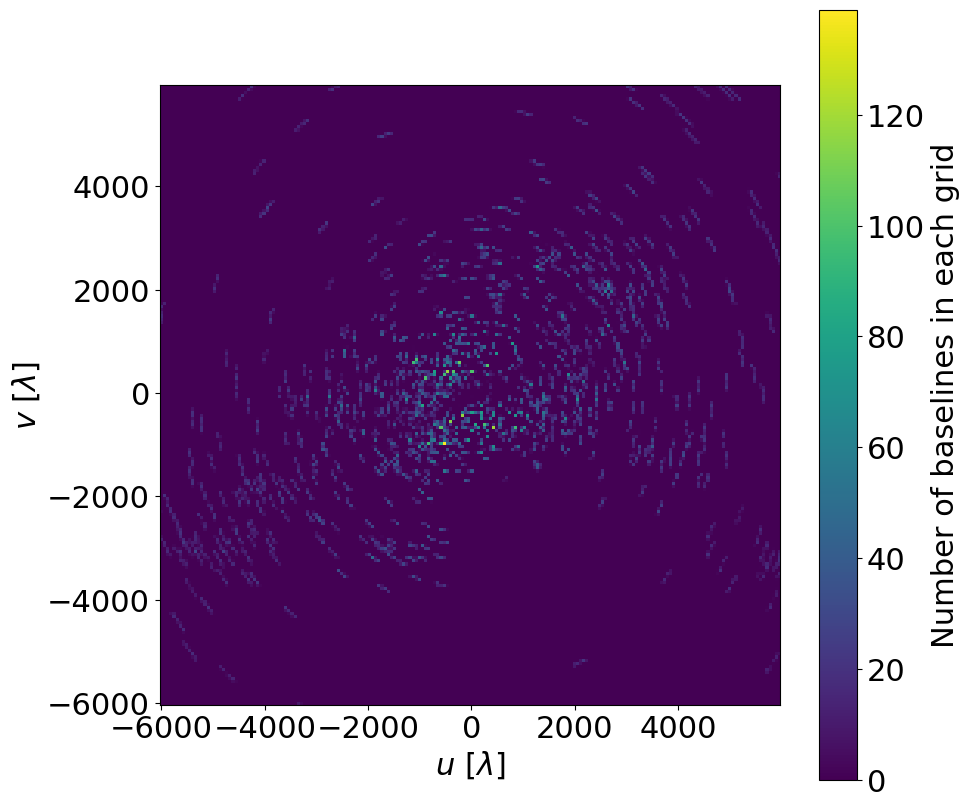

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(count_i[0].T,origin='lower',
           extent=[uvedges[0],uvedges[-1],uvedges[0],uvedges[-1]])
cax = plt.colorbar()
cax.set_label('Number of baselines in each grid')
plt.xlabel(r'$u\ [\lambda]$')
plt.ylabel(r'$v\ [\lambda]$')

Note that from `scan_id[i]` we know if this is an even or odd scan.

## `save_scan` and `muitiprocessing`

`save_scan` function basically executes `worker` and then saves the output to a folder. For example let us grid the same scan:

In [13]:
save_scan(i,(submslist,uvedges,frac,block_id[f_indx],scratch_dir,sel_ch,'I',col,fill,verbose,ignore_flag))

Reading block 1532552470 Scan 0029 10:13:38
Reading data... 10:13:38
Finished 10:13:53
Gridding... 10:13:53
Finished 10:14:01
Block 1532552470 Scan 0029 finished 10:14:01


1

You can find the files in the scratch folder

In [14]:
glob.glob(scratch_dir+"*%s*" %block_id[f_indx])

['/scratch3/users/ztchen/count_1532552470_0029_I.npy',
 '/scratch3/users/ztchen/vis_1532552470_0029_I.npy']

Let's say we want to grid the entire time block and split it into even and odd scans. With the flexibility provided by this module you can write something like this in parallel.

For some reason, if you call `worker` before multiprocessing will not work. It is recommended to run the gridding routine using slurm (see [grid_mp.py](grid_mp.py)) for an example. Restart your kernel and run the cells before the worker and then: 

In [ ]:
verbose=False
num_proc=32 # number of cores to use


#for file_indx in range(len(block_id)): # if you want to loop every time block
for file_indx in range(1): # just the first one
    print('Reading block', block_id[file_indx], datetime.datetime.now().time().strftime("%H:%M:%S"))
    # get all the scans
    submslist = np.array(glob.glob(ms_dir+block_id[file_indx]+'/sub.mms/SUBMSS/*.ms'))
    # get the scan id
    scan_id = slicer_vectorized(submslist,-7,-3)
    # initialise the grids   
    vis_even = np.zeros((num_ch,len(uvedges)-1,len(uvedges)-1),dtype='complex')
    vis_odd = np.zeros((num_ch,len(uvedges)-1,len(uvedges)-1),dtype='complex')
    if fill:
        count_even = np.zeros((len(uvedges)-1,len(uvedges)-1))
        count_odd = np.zeros((len(uvedges)-1,len(uvedges)-1))
    else:
        count_even = np.zeros((num_ch,len(uvedges)-1,len(uvedges)-1))
        count_odd = np.zeros((num_ch,len(uvedges)-1,len(uvedges)-1))
    # this part does the parallel computing
    if __name__ == '__main__':
        with Pool(num_proc) as p:
            p.starmap(save_scan, zip(range(len(scan_id)), repeat(
                (submslist,uvedges,frac,block_id[file_indx],scratch_dir,sel_ch,'I',col,fill,verbose,ignore_flag))))
    # sum over the outputs
    for scan in scan_id:
        vis_i = np.load(scratch_dir+'vis_'+block_id[file_indx]+'_'+scan+'_I.npy')
        count_i = np.load(scratch_dir+'count_'+block_id[file_indx]+'_'+scan+'_I.npy')
        if int(scan)%2 == 0:
            vis_even+=vis_i
            count_even+=count_i
        else:
            vis_odd+=vis_i
            count_odd+=count_i
    # if you want to save the outputs for each timeblock
    # uncomment this if you loop over every timeblock to save the progress
    #np.save(save_dir+'vissum_'+block_id[file_indx]+'_fill_'+str(fill)+'_odd',vis_odd)
    #np.save(save_dir+'count_'+block_id[file_indx]+'_fill_'+str(fill)+'_odd',count_odd)
    #np.save(save_dir+'vissum_'+block_id[file_indx]+'_fill_'+str(fill)+'_even',vis_even)
    #np.save(save_dir+'count_'+block_id[file_indx]+'_fill_'+str(fill)+'_even',count_even)
    # remove the temporary files
    for scan in scan_id:
        vis_file = scratch_dir+'vis_'+block_id[file_indx]+'_'+scan+'_I.npy'
        count_file = scratch_dir+'count_'+block_id[file_indx]+'_'+scan+'_I.npy'
        call(["rm", vis_file])
        call(["rm", count_file])
    print('Block finished', block_id[file_indx], datetime.datetime.now().time().strftime("%H:%M:%S"))

Reading block 1532552470 18:54:04


You can see that on 32 cores this job of 220 channels only takes about 10 min. You can launch this on max mode although always be careful with how much memory your job needs. It depends on the number of rows and the number of channels you take in. It is also straightforward to realise the same run using MPI4PY (example pending).

## `fill=True` case

Things are a little bit more complicated if you want `fill=True`. The gridding is slightly slower because of the extra step, and **much more** memory will be used due to the numpy array broadcasting. For the same DEEP2 data of 220 channels, a maximum of around 20 cores can be used before you run into memory problems. For heavilty flagged sub-bands this number can be smaller. The time one `worker` needs is:

In [15]:
i = 0
vis_i,count_i = worker(i,submslist,uvedges,frac,sel_ch,stokes='I',col=col,fill=True,verbose=True);

Reading data... 10:15:54
Finished 10:16:09
Gridding... 10:16:09
Finished 10:17:18


## Summing over the timeblocks

Once you have all the timeblocks you need in `save_dir` it's straightforward to sum over them and get the actual gridded visibility

In [20]:
vis_even = np.zeros((num_ch,len(uvedges)-1,len(uvedges)-1),dtype='complex')
vis_odd = np.zeros((num_ch,len(uvedges)-1,len(uvedges)-1),dtype='complex')
if fill:
    count_even = np.zeros((len(uvedges)-1,len(uvedges)-1))
    count_odd = np.zeros((len(uvedges)-1,len(uvedges)-1))
else:
    count_even = np.zeros((num_ch,len(uvedges)-1,len(uvedges)-1))
    count_odd = np.zeros((num_ch,len(uvedges)-1,len(uvedges)-1))

In [21]:
countlist_even = glob.glob(save_dir+'count_1*'+str(fill)+'*even*')
countlist_odd = glob.glob(save_dir+'count_1*'+str(fill)+'*odd*')
vislist_even = glob.glob(save_dir+'vissum_1*'+str(fill)+'*even*')
vislist_odd = glob.glob(save_dir+'vissum_1*'+str(fill)+'*odd*')

In [22]:
for i in range(len(countlist_even)):
    vis_even += np.load(vislist_even[i])
    vis_odd += np.load(vislist_odd[i])
    count_even += np.load(countlist_even[i])
    count_odd += np.load(countlist_odd[i])

In [23]:
vis_even = np.nan_to_num(vis_even/count_even)
vis_odd = np.nan_to_num(vis_odd/count_odd)

/tmp/ipykernel_4119567/2144761027.py:1: RuntimeWarning: invalid value encountered in true_divide
  vis_even = np.nan_to_num(vis_even/count_even)
/tmp/ipykernel_4119567/2144761027.py:2: RuntimeWarning: invalid value encountered in true_divide
  vis_odd = np.nan_to_num(vis_odd/count_odd)


Let's see the baseline distribution:

Text(0.5, 1.0, 'Odd Scan')

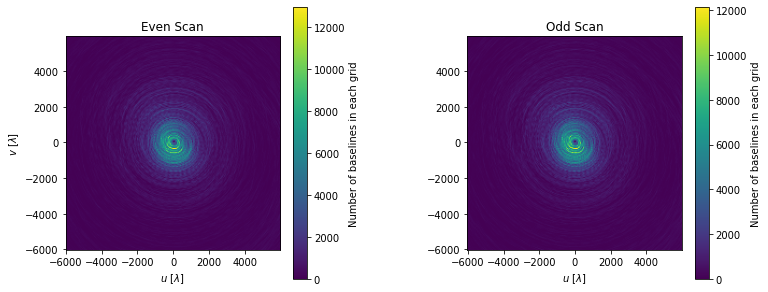

In [38]:
fig,axes = plt.subplots(1,2,figsize=(12,5),gridspec_kw={'wspace':0.5})
im0 = axes[0].imshow(count_even[0].T,origin='lower',
           extent=[uvedges[0],uvedges[-1],uvedges[0],uvedges[-1]])
cax0 = fig.colorbar(im0,ax=axes[0])
cax0.set_label('Number of baselines in each grid')
axes[0].set_xlabel(r'$u\ [\lambda]$')
axes[0].set_ylabel(r'$v\ [\lambda]$')
axes[0].set_title('Even Scan')
im1 = axes[1].imshow(count_odd[0].T,origin='lower',
           extent=[uvedges[0],uvedges[-1],uvedges[0],uvedges[-1]])
cax1 = fig.colorbar(im1,ax=axes[1])
cax1.set_label('Number of baselines in each grid')
axes[1].set_xlabel(r'$u\ [\lambda]$')
axes[1].set_title('Odd Scan')

The amplitude of the visibility in log scale:

/tmp/ipykernel_4119567/2491246449.py:2: RuntimeWarning: divide by zero encountered in log10
  im0 = axes[0].imshow(np.log10(np.abs(vis_even[0]).T),origin='lower',
/tmp/ipykernel_4119567/2491246449.py:9: RuntimeWarning: divide by zero encountered in log10
  im1 = axes[1].imshow(np.log10(np.abs(vis_odd[0]).T),origin='lower',


Text(0.5, 1.0, 'Odd Scan')

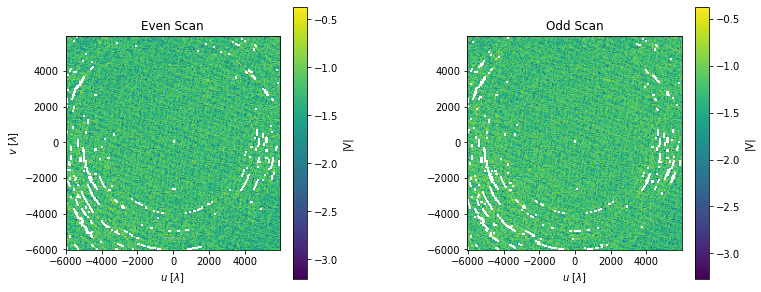

In [41]:
fig,axes = plt.subplots(1,2,figsize=(12,5),gridspec_kw={'wspace':0.5})
im0 = axes[0].imshow(np.log10(np.abs(vis_even[0]).T),origin='lower',
           extent=[uvedges[0],uvedges[-1],uvedges[0],uvedges[-1]])
cax0 = fig.colorbar(im0,ax=axes[0])
cax0.set_label('|V|')
axes[0].set_xlabel(r'$u\ [\lambda]$')
axes[0].set_ylabel(r'$v\ [\lambda]$')
axes[0].set_title('Even Scan')
im1 = axes[1].imshow(np.log10(np.abs(vis_odd[0]).T),origin='lower',
           extent=[uvedges[0],uvedges[-1],uvedges[0],uvedges[-1]])
cax1 = fig.colorbar(im1,ax=axes[1])
cax1.set_label('|V|')
axes[1].set_xlabel(r'$u\ [\lambda]$')
axes[1].set_title('Odd Scan')